In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import os
import sys

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from utils import (
    load_json,
    save_json,
    load_txt,
    save_txt,
)

In [14]:
df = pd.read_csv('./data/train.csv')
df.shape

(860, 4)

In [15]:
df.head(3)

,ID,Sentiment,Text,Dialect
0,1071.0,neutral,الشاطئ ممتاز لكن ماهو نظيف,Saudi
1,2090.0,negative,فندق خايب بزاف، هاد الفندق من أسوأ الفنادق الل...,Darija
2,2242.0,negative,رابعا، ما كينش فراشات زايدين فالبيوت، وحتى فا...,Darija


In [16]:
# count the rows per dialects
dialect_counts = df['Dialect'].value_counts()
dialect_counts

Dialect
Saudi     430
Darija    430
Name: count, dtype: int64

In [17]:
# count the rows per sentiment
sentiment_counts = df['Sentiment'].value_counts()
sentiment_counts

Sentiment
negative    336
positive    308
neutral     216
Name: count, dtype: int64

In [18]:
# count the sentiment per dialect
dialect_sentiment_counts = df.groupby(['Dialect', 'Sentiment']).size().unstack(fill_value=0)
dialect_sentiment_counts

Sentiment,negative,neutral,positive
Dialect,,,
Darija,168,108,154
Saudi,168,108,154


In [19]:
def count_words(text):
    """ Count the number of words in a given text. """
    return len(text.split())

# count the number of words in each text
df['word_count'] = df['Text'].apply(count_words)

# count the average number of words per sentiment per dialect
avg_word_count = df.groupby(['Dialect', 'Sentiment'])['word_count'].mean().unstack()
avg_word_count


Sentiment,negative,neutral,positive
Dialect,,,
Darija,19.589286,20.351852,22.623377
Saudi,19.000000,19.509259,22.805195


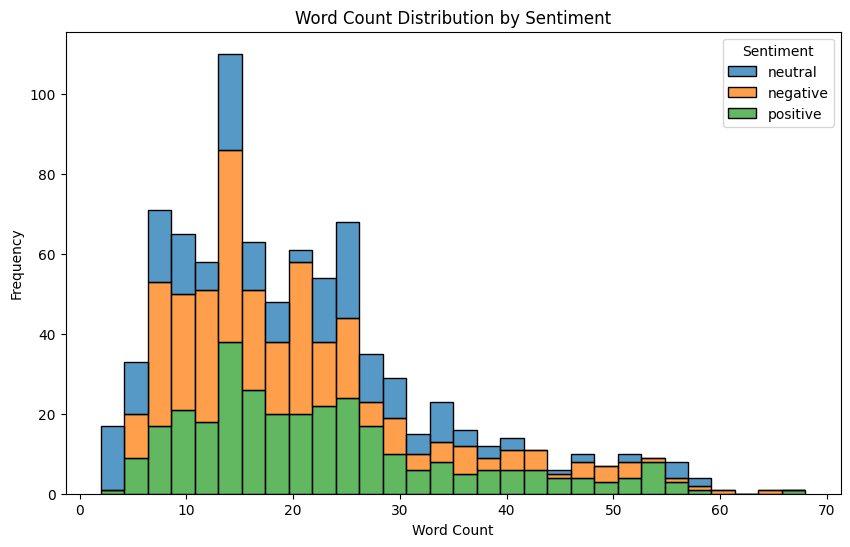

In [20]:
# --- Word count distribution plot ---
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='word_count', hue='Sentiment', multiple='stack', bins=30)
plt.title('Word Count Distribution by Sentiment')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


In [21]:
def count_chars(text):
    """ Count the number of words in a given text. """
    return len(text)

# count the number of words in each text
df['char_count'] = df['Text'].apply(count_chars)

# count the average number of words per sentiment per dialect
avg_word_count = df.groupby(['Dialect', 'Sentiment'])['char_count'].mean().unstack()
avg_word_count


Sentiment,negative,neutral,positive
Dialect,,,
Darija,111.148810,114.675926,127.220779
Saudi,96.970238,100.240741,118.272727


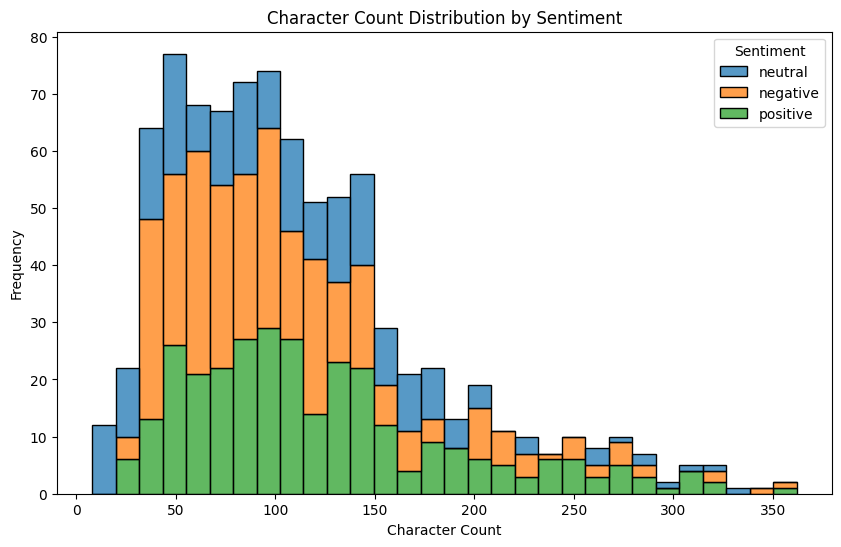

In [22]:
# --- Character count distribution plot ---
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='char_count', hue='Sentiment', multiple='stack', bins=30)
plt.title('Character Count Distribution by Sentiment')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.show()


In [23]:
# --- Most common words (Optional deeper analysis) ---
from collections import Counter

def get_top_n_words(corpus, n=None):
    words = [word for text in corpus for word in str(text).split()]
    counter = Counter(words)
    return counter.most_common(n)

print("\nTop 20 words overall:")
print(get_top_n_words(df['Text'], 20))

for sentiment in df['Sentiment'].unique():
    print(f"\nTop 20 words for Sentiment = {sentiment}:")
    subset = df[df['Sentiment'] == sentiment]
    print(get_top_n_words(subset['Text'], 20))



Top 20 words overall:
[('و', 972), ('من', 430), ('في', 330), ('ما', 320), ('الفندق', 263), ('اللي', 201), ('كان', 196), ('فيه', 191), ('فندق', 178), ('على', 165), ('مره', 145), ('ديال', 129), ('كانت', 114), ('كل', 108), ('بزاف', 97), ('شي', 97), ('الغرف', 86), ('مع', 85), ('هاد', 84), ('هذا', 77)]

Top 20 words for Sentiment = neutral:
[('و', 227), ('من', 91), ('ما', 77), ('في', 67), ('كان', 65), ('الفندق', 57), ('اللي', 46), ('فندق', 44), ('فيه', 43), ('ولكن', 33), ('كانت', 32), ('على', 31), ('ديال', 31), ('شي', 31), ('مره', 29), ('جيد', 25), ('بالنسبة', 24), ('لكن', 22), ('بس', 22), ('قريب', 22)]

Top 20 words for Sentiment = negative:
[('و', 291), ('ما', 200), ('من', 144), ('في', 107), ('الفندق', 85), ('اللي', 73), ('فيه', 72), ('على', 59), ('كان', 58), ('مره', 54), ('ديال', 46), ('حتى', 40), ('فندق', 38), ('لا', 37), ('هذا', 37), ('شي', 37), ('الغرف', 35), ('هاد', 31), ('بزاف', 31), ('كانت', 30)]

Top 20 words for Sentiment = positive:
[('و', 454), ('من', 195), ('في', 156), ('الفن

In [24]:
# --- Special Characters analysis (Optional) ---
# Check for weird chars like '؟', emojis, etc.
df['has_question_mark'] = df['Text'].apply(lambda x: '?' in str(x) or '؟' in str(x))
print("\nTexts containing question marks (Arabic/Latin):")
print(df['has_question_mark'].value_counts())


Texts containing question marks (Arabic/Latin):
has_question_mark
False    857
True       3
Name: count, dtype: int64


In [25]:
# --- Phase 2: Smart Arabic Exploration ---

# --- 1. Negation Detection ---
negation_words = [
    'ما', 'مش', 'مو', 'ليس', 'لا', 'مافي', 'مافيش', 'ماكانش', 'مازال', 'ماكانوش',
    'مكينش', 'ماشي', 'ماعنديش', 'ماعندكش', 'ماعندهمش', 'مفيش', 'ماجاش', 'ماصارش', 'ماكيتشافش',
    'موش', 'منيش', 'منيشي', 'ماخدمتش', 'مايصلحش', 'مايستاهلش', 'مايجيش', 'ماعديش', 'مايسواش'
]
df['has_negation'] = df['Text'].apply(lambda x: any(word in str(x).split() for word in negation_words))
print("\nNegation presence:")
print(df['has_negation'].value_counts())



Negation presence:
has_negation
False    553
True     307
Name: count, dtype: int64


In [26]:
# --- 3. Emoji and Emphasis Detection ---
emoji_pattern = re.compile("[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]")
df['has_emoji'] = df['Text'].apply(lambda x: bool(emoji_pattern.search(str(x))))
df['has_exclam'] = df['Text'].apply(lambda x: '!' in str(x) or '！' in str(x))
df['has_repeat_char'] = df['Text'].apply(lambda x: bool(re.search(r'(.)\1{2,}', str(x))))

print("\nSpecial character signals:")
print("Emojis:", df['has_emoji'].sum())
print("Exclamations:", df['has_exclam'].sum())
print("Repeated characters:", df['has_repeat_char'].sum())

NameError: name 're' is not defined

In [ ]:
# --- 4. Sentiment Lexicon Matching ---
positive_words = ['جميل', 'ممتاز', 'جيد', 'رائع', 'نظيف', 'مريح', 'هايل', 'زين']
negative_words = ['سيئ', 'خايب', 'قذر', 'قبيح', 'خدمة خايبة', 'زفت', 'غالي', 'وسخ']

def has_lexicon_word(text, wordlist):
    return any(word in str(text) for word in wordlist)

df['has_positive_word'] = df['Text'].apply(lambda x: has_lexicon_word(x, positive_words))
df['has_negative_word'] = df['Text'].apply(lambda x: has_lexicon_word(x, negative_words))

print("\nSentiment lexicon signals:")
print("Contains positive word:", df['has_positive_word'].sum())
print("Contains negative word:", df['has_negative_word'].sum())

# --- Lexicon match vs Sentiment label ---
print("\nLabel distribution by lexicon match:")
print("\nIf positive word present:")
print(df[df['has_positive_word'] == True]['Sentiment'].value_counts())
print("\nIf negative word present:")
print(df[df['has_negative_word'] == True]['Sentiment'].value_counts())
print("\nIf neither present:")
print(df[(df['has_positive_word'] == False) & (df['has_negative_word'] == False)]['Sentiment'].value_counts())



Sentiment lexicon signals:
Contains positive word: 227
Contains negative word: 95

Label distribution by lexicon match:

If positive word present:
Sentiment
positive    140
neutral      60
negative     27
Name: count, dtype: int64

If negative word present:
Sentiment
negative    87
neutral      6
positive     2
Name: count, dtype: int64

If neither present:
Sentiment
negative    227
positive    166
neutral     153
Name: count, dtype: int64
